# Recommender System Data Wrangling

## Problem Definition

A recommender system is a system that predicts a user's rating on an item. Based upon the ratings, we could recommend top-rated items for each user. 

The boosting internet brings us many more options than before. When we browse, it is hard and time-consuming for customers to choose what they like out of thousands of possible choices. This is where the recommender system comes in.

In order to run smoothly. We only take last two weeks' records.

## Load data into Spark DataFrame

In [1]:
from pyspark import SparkContext
import pyspark.sql.functions as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
df = spark.read.csv('../data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

## Data Exploration

### Data cleansing

#### Features' Type Casting and Verification

In [26]:
df = df.withColumn('date', F.col('date').cast('date'))
for col in ['uid', 'song_id']:
    df = df.withColumn(col, F.col(col).cast('int'))
df

DataFrame[uid: int, event: string, song_id: int, date: date]

#### Missing Value Inputation

In [5]:
df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+-----+-------+----+
|uid|event|song_id|date|
+---+-----+-------+----+
|  0|    0| 774576|   0|
+---+-----+-------+----+



In [4]:
df.count()

10757820

#### Exclude song_id == 0, i.e. song_id is missing

In [27]:
df = df.filter(F.col('song_id') > 0)

In [8]:
# df.select(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+-----+-------+----+
|uid|event|song_id|date|
+---+-----+-------+----+
|  0|    0|      0|   0|
+---+-----+-------+----+



#### Exclude inactive users
18732 records are removed. `df.count()-df_play_active.count() = 10721905 - 10703173 = 18372`

In [28]:
user_song_count = df.groupBy('uid').agg(F.count(F.col('song_id')).alias('songs_played'))      

In [6]:
# count the total number of users
user_song_count.count()

57944

In [30]:
# count the number of inactive users
inactive_user = user_song_count.filter('songs_played < 5')
inactive_user.count()

21890

In [31]:
df_play_join = df.join(user_song_count, 'uid')

In [32]:
df_play_active = df_play_join.filter(F.col('songs_played') >= 5)

In [33]:
# df_play_active.show(5)

In [14]:
# df_play_active.count() # 10703173

10703173

song id, user id

In [13]:
df_play_active.select('uid').distinct().count(), df_play_active.select('song_id').distinct().count()

(48847, 470423)

In [14]:
df_play_active.select('uid', 'song_id').distinct().count()

3355846

In [15]:
df.select(F.min(F.col('date')).alias('start_date'), F.max(F.col('date')).alias('end_date')).show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|2017-03-30|2017-05-12|
+----------+----------+



In [16]:
date_count = df.groupBy('date').count().toPandas()

(array([736419., 736426., 736433., 736440., 736447., 736454., 736461.]),
 <a list of 7 Text xticklabel objects>)

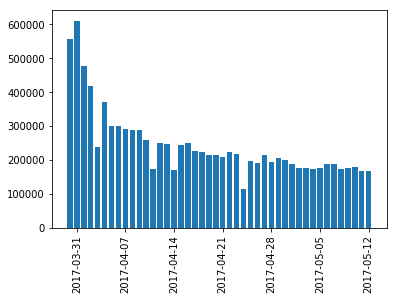

In [17]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt
# This statement allow to display plot without asking to
%matplotlib inline
plt.bar(date_count.date.tolist(), date_count['count'])
plt.xticks(rotation='vertical')

## Generation of Implicit Rating

#### Frequency

In [34]:
import datetime
from dateutil import parser

reco_window_size= 14 
reco_window_end_date = parser.parse('2017-05-12').date()
reco_window_start_date = reco_window_end_date - datetime.timedelta(reco_window_size - 1)
print('recommendation window:', reco_window_start_date, '~', 
      reco_window_end_date, '\ndays:', reco_window_size)

recommendation window: 2017-04-29 ~ 2017-05-12 
days: 14


In [35]:
def frequency_reco_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid', 'song_id') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [36]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D']
time_window_list = [14]
snapshot_date = reco_window_end_date

df_rec_list = []
for event in event_list:
    df_rec_list.append(frequency_reco_generation_time_windows(df,event,
                                                                     time_window_list,snapshot_date))

In [37]:
df_rec_list

[DataFrame[uid: int, song_id: int, freq_P_last_14: bigint],
 DataFrame[uid: int, song_id: int, freq_D_last_14: bigint]]

#### Play Time/Song Length

In [38]:
df_play = spark.read.csv('../data/play_ds.csv',header=True)
df_play.show(5)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168551247|    ar|11881432|2017-03-30|       78|        149|
|168551026|    ar|19477157|2017-03-30|        2|         31|
|168551430|    ar| 1179220|2017-03-30|      231|        231|
|168548714|    ar|23492572|2017-03-30|        2|        359|
|168550890|    ar|23491657|2017-03-30|      330|        331|
+---------+------+--------+----------+---------+-----------+
only showing top 5 rows



In [39]:
# df_play_feature_window.show(10)
df_profile = df_play.drop('device').distinct() \
    .withColumn('uid', F.col('uid').cast('int')) \
    .withColumn('song_id', F.col('song_id').cast('int')) \
    .withColumn('play_time', F.col('play_time').cast("float")) \
    .withColumn('song_length', F.col('song_length').cast('float'))


#### Play Time and Song Length Cleansing

In [40]:
df_profile = df_profile.filter((F.col('play_time') > 0) & (F.col('song_length') > 0) \
                              & (F.col('play_time') <= F.col('song_length')))
# df_profile.describe().show()
df_profile.show(10)

+---------+-------+----------+---------+-----------+
|      uid|song_id|      date|play_time|song_length|
+---------+-------+----------+---------+-----------+
|169028184|   null|2017-04-01|    199.0|      199.0|
|167978413|   null|2017-04-01|    212.0|      212.0|
|169028184|   null|2017-03-30|    255.0|      255.0|
|168126865|   null|2017-04-03|    286.0|      286.0|
|156937783|      0|2017-03-30|      1.0|      291.0|
|168671782|      0|2017-03-30|      1.0|      209.0|
|168741053|      0|2017-03-30|      1.0|      282.0|
|168817641|      0|2017-03-30|      1.0|      219.0|
|168817641|      0|2017-03-30|      1.0|      234.0|
|168858906|      0|2017-03-30|      1.0|       61.0|
+---------+-------+----------+---------+-----------+
only showing top 10 rows



In [18]:
# median_song_length = df_profile.approxQuantile('song_length', [0.5], 0.01)

# df_profile = df_profile.withColumn('song_length', F.when(df_profile['song_length'] == 0, median_song_length[0]) \
#                                   .otherwise(df_profile['song_length']))

In [41]:
# feature: play_time/song_length
def relative_freq_reco_generation_time_windows(df,time_window_list,snapshot_date):
    """
    generate counts of songs play 80% of their song length (using play_ds data) for different time window
    """
    df_feature = df \
        .groupBy('uid', 'song_id') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date) \
                            & (F.col('play_time')/F.col('song_length')>=0.8),1).otherwise(0))\
               .alias('rela_freq_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [42]:
time_window_list = [14]
snapshot_date = reco_window_end_date
df_rela_freq_reco = relative_freq_reco_generation_time_windows(df_profile, time_window_list, snapshot_date)
df_rela_freq_reco

DataFrame[uid: int, song_id: int, rela_freq_last_14: bigint]

### Join all feature datasets together

In [43]:
def join_reco_data(df_reco_list):
    df_master = df_reco_list[0]
    df_reco_list.pop(0)
    for df_reco in df_reco_list:
        df_master = df_master.join(df_reco,on=['uid','song_id'],how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master

In [44]:
df_rec_list_copy = df_rec_list.copy()
df_rec_list_copy.append(df_rela_freq_reco)
df_rec_final = join_reco_data(df_rec_list_copy)
df_rec_final

DataFrame[uid: int, song_id: int, freq_P_last_14: bigint, freq_D_last_14: bigint, rela_freq_last_14: bigint]

In [45]:
df_rec_final.count()

2940821

In [66]:
df_rec_final = df_rec_final.fillna(0).toPandas()

In [34]:
df_rec_final.to_csv('../data/df_rec_final.csv',index=False)

In [19]:
df_rec_final = pd.read_csv('../data/df_rec_final.csv')